In [22]:
import torch
import numpy as np
import cifar_data
import NN_models.wide_resnet as wide_resnet
import NN_utils as utils
from NN_utils import train_and_eval as TE
from torch import nn
import matplotlib.pyplot as plt
import NN_models
import uncertainty.utils as unc_utils
import uncertainty as unc
from sklearn.metrics import roc_curve as ROC
import sklearn

In [2]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


In [71]:
PATH = r'/home/luis-felipe/Uncertainty_Estimation/torch_models'
PATH_trainer = r'/home/luis-felipe/Uncertainty_Estimation/torch_models/trainer'
#cifar = cifar_data.Cifar_10_data()
cifar = cifar_data.Cifar_100_data()

Files already downloaded and verified
Files already downloaded and verified


In [72]:
model = NN_models.Model_CNN(n_classes = cifar.n_classes).to(dev)
#model = wide_resnet.Wide_ResNet(num_classes = 10,dropout_rate = 0.3).to(dev)
model.load_state_dict(torch.load(PATH + r'/' + 'simple_cifar'+str(cifar.n_classes)+ '.pt'))
model.classifier_layer[1] = torch.nn.Softmax(dim=-1)
model_mcd = lambda x: unc.get_MCD(model,x,n=10)


In [87]:
def accumulate_results_mcd(model,data):
    '''Accumulate output (of model) and label of a entire dataset.'''

    output_list = torch.Tensor([]).to(dev)
    var_list = torch.Tensor([]).to(dev)
    MI_list = torch.Tensor([]).to(dev)
    label_list = torch.Tensor([]).to(dev)
    for image,label in data:
        with torch.no_grad():
            image,label = image.to(dev), label.to(dev)
            output = torch.exp(model(image)[0])
            var = model(image)[1]
            MI = model(image)[2]

            label_list = torch.cat((label_list,label))
            var_list = torch.cat((var_list,var))
            MI_list = torch.cat((MI_list,MI))
            output_list = torch.cat((output_list,output))
    return output_list,label_list.long(),var_list,MI_list

def accumulate_results(model,data):
    '''Accumulate output (of model) and label of a entire dataset.'''

    output_list = torch.Tensor([]).to(dev)
    label_list = torch.Tensor([]).to(dev)
    for image,label in data:
        with torch.no_grad():
            image,label = image.to(dev), label.to(dev)
            output = torch.exp(model(image))

            label_list = torch.cat((label_list,label))
            output_list = torch.cat((output_list,output))
    return output_list,label_list.long()

def model_acc(model,data):
    '''Returns the total accuracy of model in some dataset'''
    with torch.no_grad():
        total = 0
        correct= 0
        for image,label in data:
            image,label = image.to(dev), label.to(dev)
            output = model(image)[0]
            total += label.size(0)
            correct += TE.correct_total(output,label)
    return (correct*100/total)

In [ ]:
a=1

In [88]:
image,_ = next(iter(cifar.test_dataloader))
image = image.cuda()
var = unc_utils.montecarlo_pred(model,image)

In [89]:
output, label,var,MI = accumulate_results_mcd(model_mcd,cifar.test_dataloader)
#output, label = accumulate_results(model,cifar.test_dataloader)

In [94]:
c_list = np.arange(0.05,1.05,0.05)
acc_list_mcp = unc_utils.acc_coverage_list(output,label,unc.MCP_unc(output), c_list)
acc_list_entropy = unc_utils.acc_coverage_list(output,label,unc.entropy(output), c_list)
acc_list_var = unc_utils.acc_coverage_list(output,label,var, c_list)
acc_list_MI = unc_utils.acc_coverage_list(output,label,MI, c_list)

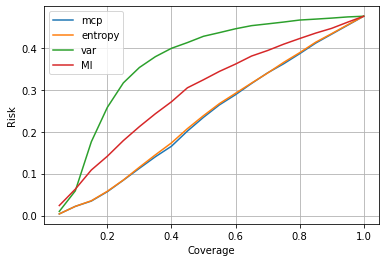

In [95]:
plt.plot(c_list,1-acc_list_mcp,label = 'mcp')
plt.plot(c_list,1-acc_list_entropy, label = 'entropy')
plt.plot(c_list,1-acc_list_var,label = 'var')
plt.plot(c_list,1-acc_list_MI, label = 'MI')
plt.legend()
plt.xlabel("Coverage")
plt.ylabel("Risk")
plt.grid()
plt.show()

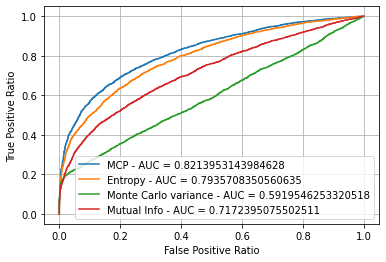

In [78]:
y_true = TE.correct_class(output,label).cpu().numpy()
fpr, tpr, thresholds = ROC(y_true,unc.get_MCP(output).cpu().numpy())
plt.plot(fpr, tpr, label = f'MCP - AUC = {sklearn.metrics.auc(fpr, tpr)}')

fpr, tpr, thresholds = ROC(y_true,-unc.entropy(output).cpu().numpy())
plt.plot(fpr, tpr, label = f'Entropy - AUC = {sklearn.metrics.auc(fpr, tpr)}')

fpr, tpr, thresholds = ROC(y_true,-var.cpu().numpy())
plt.plot(fpr, tpr, label = f'Monte Carlo variance - AUC = {sklearn.metrics.auc(fpr, tpr)}')

fpr, tpr, thresholds = ROC(y_true,-MI.cpu().numpy())
plt.plot(fpr, tpr, label = f'Mutual Info - AUC = {sklearn.metrics.auc(fpr, tpr)}')

plt.legend()
plt.xlabel("False Positive Ratio")
plt.ylabel("True Positive Ratio")
plt.grid()
plt.show()

(array([ 854.,  640.,  612.,  716.,  861., 1051., 1343., 1579., 1730.,
         614.]),
 array([5.9604645e-08, 9.5208228e-02, 1.9041640e-01, 2.8562456e-01,
        3.8083273e-01, 4.7604090e-01, 5.7124907e-01, 6.6645724e-01,
        7.6166540e-01, 8.5687357e-01, 9.5208174e-01], dtype=float32),
 <BarContainer object of 10 artists>)

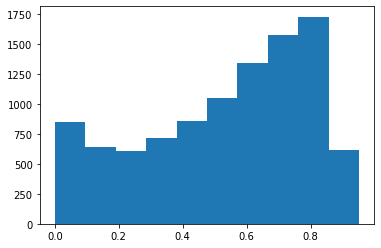

In [79]:
plt.hist(unc.MCP_unc(output).cpu().numpy())

(array([2031., 3295., 2506., 1277.,  562.,  209.,   73.,   35.,    4.,
           8.]),
 array([3.4555031e-14, 4.0747219e-04, 8.1494439e-04, 1.2224166e-03,
        1.6298888e-03, 2.0373610e-03, 2.4448333e-03, 2.8523055e-03,
        3.2597776e-03, 3.6672498e-03, 4.0747221e-03], dtype=float32),
 <BarContainer object of 10 artists>)

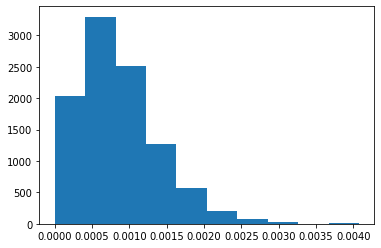

In [80]:
plt.hist(var.cpu().numpy())

In [ ]:
for T in range(1,10):
    model_mcd = lambda x: unc.get_MCD(model,x,n=T)
    print(T, ':  ')
    print(model_acc(model_mcd,cifar.test_dataloader))

Text(0.5, 1.0, 'Entropy - MCP')

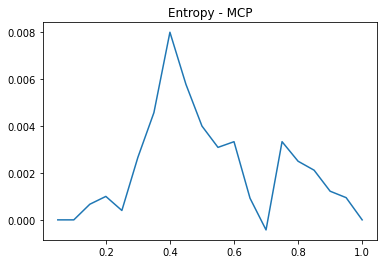

In [96]:
plt.plot(c_list,(1-acc_list_entropy)-(1-acc_list_mcp))
plt.title("Entropy - MCP")

In [34]:
def predict_proba_with_tta(data, 
                           model, 
                           dummies = None, 
                           num_tta = 4, 
                           alpha   = 0.01, 
                           beta    = 0.01, 
                           seed    = 0):
    '''
    Predicts class probabilities using TTA.
    
    Arguments:
    - data (numpy array): data set with the feature values 
    - model (sklearn model): machine learning model
    - dummies (list): list of column names of dummy features
    - num_tta (integer): number of test-time augmentations
    - alpha (float): noise parameter for continuous features
    - beta (float): noise parameter for dummy features
    - seed (integer): random seed

    Returns:
    - array of predicted probabilities
    '''
    
    # set random seed
    np.random.seed(seed = seed)
    
    # original prediction
    preds = model(data) / (num_tta + 1)
     
    # select numeric features
    num_vars = [var for var in data.columns if data[var].dtype != 'object']
        
    # find dummies
    if dummies != None:
        num_vars = list(set(num_vars) - set(dummies))
    
    # synthetic predictions
    for i in range(num_tta):
        
        # copy data
        data_new = data.copy()
    
        # introduce noise to numeric vars
        for var in num_vars:
            data_new[var] = data_new[var] + alpha * np.random.normal(0, 1, size = len(data_new)) * data_new[var].std()
            
        # introduce noise to dummies
        if dummies != None:
            for var in dummies:
                probs = np.random.binomial(1, (1 - beta), size = len(data_new))
                data_new.loc[probs == 0, var] = 1 - data_new.loc[probs == 0, var]
            
        # predict probs
        preds_new = model(data_new) 
        preds    += preds_new / (num_tta + 1)
    
    # return probs
    return preds

In [36]:
predict_proba_with_tta(image,model)

AttributeError: 'Tensor' object has no attribute 'columns'